In [1]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# task a

In [ ]:
df_sales = pd.read_csv("/content/Alcohol_Sales.csv")
df_sales.head()

,DATE,S4248SM144NCEN
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221


In [ ]:
df_sales.shape

(325, 2)

In [ ]:
df_sales.columns = ["DATE", "SALES"]

In [ ]:
df_sales.head()

,DATE,SALES
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221


In [ ]:
df_sales.dtypes

DATE     object
SALES     int64
dtype: object

In [ ]:
df_sales['DATE'] = pd.to_datetime(df_sales['DATE'])
df_sales.set_index('DATE', inplace=True)

In [ ]:
train_data, test_data = train_test_split(df_sales, test_size=0.2, shuffle=False)


In [ ]:
scaler = StandardScaler()
train_data['SALES'] = scaler.fit_transform(train_data[['SALES']])
test_data['SALES'] = scaler.transform(test_data[['SALES']])


In [ ]:
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i + sequence_length]
        target = data.iloc[i + sequence_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 10  # Adjust this value as needed
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))  # Output layer for forecasting

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
8/8 [==============================] - 2s 52ms/step - loss: 0.8510 - val_loss: 4.8219
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.6357 - val_loss: 3.2489
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.4092 - val_loss: 1.3042
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.2071 - val_loss: 3.4554
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.1948 - val_loss: 1.9476
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 0.1734 - val_loss: 0.5668
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 0.1728 - val_loss: 0.6402
Epoch 8/100
8/8 [==============================] - 0s 16ms/step - loss: 0.1617 - val_loss: 1.1642
Epoch 9/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1651 - val_loss: 1.0874
Epoch 10/100
8/8 [==============================] - 0s 14ms/step - loss: 0.1626 - val_loss: 0.8392
Epoch 11/100
8/8 [=

In [ ]:
from sklearn.metrics import mean_squared_error

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')


2/2 [==============================] - 0s 7ms/step
Root Mean Squared Error (RMSE): 1.1419441638625467


# task b

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

2023-09-20 20:33:03.653921: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-20 20:33:07.000415: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-20 20:33:07.001240: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-20 20:33:11.834773: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [57]:
df_miles = pd.read_csv("data/task4/Miles_Traveled.csv")

In [58]:
df_miles.head(3)

,DATE,TRFVOLUSM227NFWA
0,1970-01-01,80173.0
1,1970-02-01,77442.0
2,1970-03-01,90223.0


In [59]:
df_miles.columns = ["DATE", "MILES"]

In [60]:
df_miles['DATE'] = pd.to_datetime(df_miles['DATE'])
df_miles.sort_values(by='DATE', inplace=True)
df_miles[:20]

,DATE,MILES
0,1970-01-01,80173.0
1,1970-02-01,77442.0
2,1970-03-01,90223.0
3,1970-04-01,89956.0
4,1970-05-01,97972.0
5,1970-06-01,100035.0
6,1970-07-01,106392.0
7,1970-08-01,106969.0
8,1970-09-01,95254.0
9,1970-10-01,96317.0


In [61]:
df_miles.index = pd.to_datetime(df_miles["DATE"])

In [64]:
df_miles = df_miles.drop(columns=["DATE"])
df_miles.head(3)

,MILES
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0


<Axes: xlabel='DATE'>

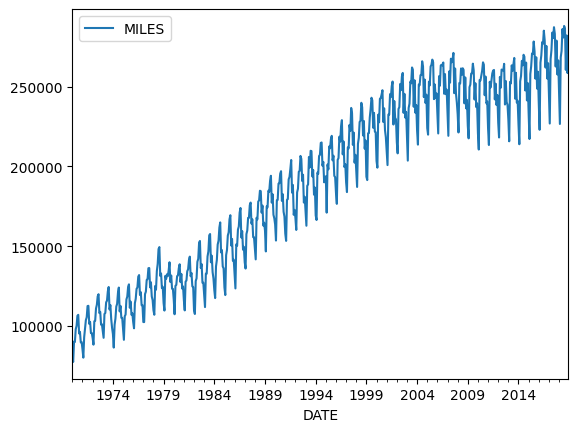

In [77]:
df_miles.plot()

In [78]:
def df_to_X_y(df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        # to make a list of list
        row = [[a] for a in df_as_np[i:i+5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)

    return np.array(X), np.array(y)

In [83]:
X, y = df_to_X_y(df_miles, 7)
X.shape, y.shape

((581, 5, 1, 1), (581, 1))

In [85]:
# 70:30 split
split_index = int(len(df_miles) * 0.7)

X_train = X[:split_index]
y_train = y[:split_index]
X_test = X[split_index:]
y_test = y[split_index:]

In [86]:
model = Sequential()
model.add(InputLayer((5,1)))
model.add(LSTM(64))
model.add(Dense(8, "relu"))
model.add(Dense(1, "linear"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [88]:
model.compile(loss = MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [89]:
# get validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [90]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 10)

Epoch 1/10
11/11 [==============================] - 2s 39ms/step - loss: 23452928000.0000 - root_mean_squared_error: 153143.4844 - val_loss: 53876617216.0000 - val_root_mean_squared_error: 232113.3750
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 23452921856.0000 - root_mean_squared_error: 153143.4688 - val_loss: 53876600832.0000 - val_root_mean_squared_error: 232113.3438
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 23452911616.0000 - root_mean_squared_error: 153143.4375 - val_loss: 53876592640.0000 - val_root_mean_squared_error: 232113.3125
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 23452905472.0000 - root_mean_squared_error: 153143.4219 - val_loss: 53876580352.0000 - val_root_mean_squared_error: 232113.2969
Epoch 5/10
11/11 [==============================] - 0s 4ms/step - loss: 23452899328.0000 - root_mean_squared_error: 153143.3906 - val_loss: 53876568064.0000 - val_root_mean_squared_error: 232113.2656

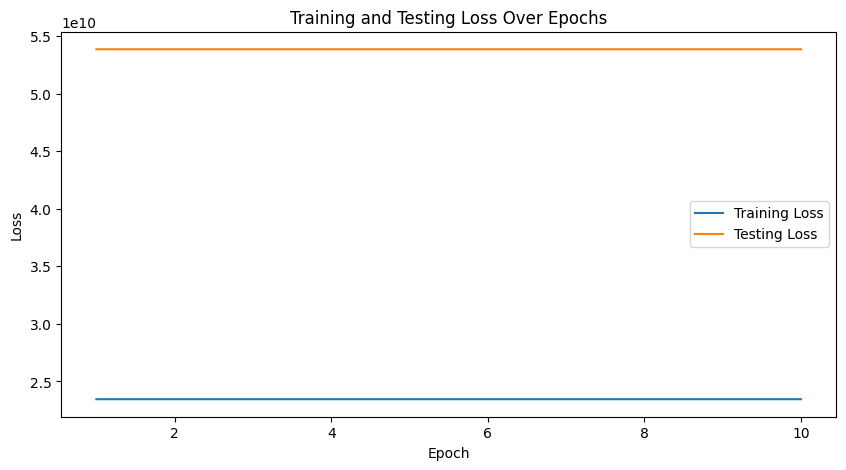

In [92]:
import matplotlib.pyplot as plt

training_loss = history.history['loss']
testing_loss = history.history['val_loss']

epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, testing_loss, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.show()

In [100]:
train_predictions = model.predict(X_test).flatten()
train_results = pd.DataFrame({'Train Predictions': train_predictions, 'Actuals': y_test.flatten()})
train_results

6/6 [==============================] - 0s 1ms/step


,Train Predictions,Actuals
0,-0.434001,243515.0
1,-0.434001,254496.0
2,-0.434001,239796.0
3,-0.434001,245029.0
4,-0.434001,224072.0
...,...,...
165,-0.434001,280877.0
166,-0.434001,288145.0
167,-0.434001,286608.0
168,-0.434001,260595.0


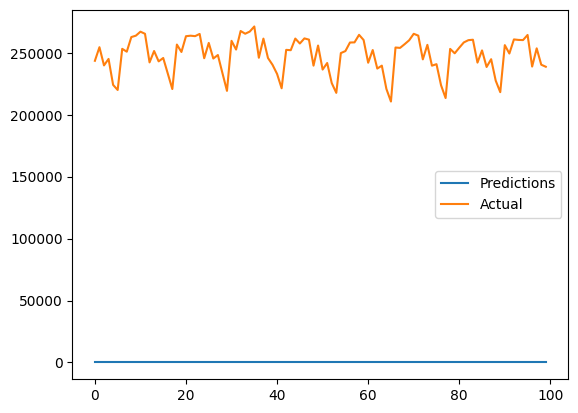

In [102]:
plt.plot(train_results['Train Predictions'][:100], label = "Predictions")
plt.plot(train_results['Actuals'][:100], label = "Actual")
plt.legend()
plt.show()

In [103]:
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

6/6 [==============================] - 0s 2ms/step
Root Mean Squared Error (RMSE): 253681.61127634672
